## Day 34 Lecture 1 Assignment

In this assignment, we will learn about SVR. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.svm import SVC, SVR

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
absent = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv', sep=';')

In [3]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


We previously used this dataset for KNN regression. Recall that we removed all correlated columns as well as columns that are a function of two or more other columns (like BMI and weight and height) as well as columns that are not useful to us (like ID).
We also created dummy variables for the categorical columns in our dataset.
Finally, we split the data into test and train (with test being 20% of the data).

Perform these actions below.

In [4]:
#answer below:
absent.drop('Weight', 1, inplace=True)
absent.drop('ID', 1, inplace=True)
absent['Reason_groups'] = np.where(absent['Reason for absence'] == 0, 'Disciplinary', 
                                   np.where(absent['Reason for absence'] < 15, 'Disease',
                                   np.where(absent['Reason for absence'] < 22, 'Not_Disease', 'Other')))
absent = pd.concat([absent,
                    pd.get_dummies(absent['Reason_groups'], prefix='Reason', drop_first=True)],
                   axis = 1)
absent.drop(['Reason for absence', 'Reason_groups'], 1, inplace=True)

absent = absent.loc[absent['Month of absence'] != 0]

absent.drop('Month of absence', 1, inplace=True)

absent = pd.concat([absent,
                    pd.get_dummies(absent['Seasons'], prefix='Season', drop_first=True)],
                   axis = 1)

absent.drop('Seasons', 1, inplace=True)

absent = pd.concat([absent,
                    pd.get_dummies(absent['Day of the week'], prefix='Day', drop_first=True)],
                   axis = 1)

absent.drop('Day of the week', 1, inplace=True)

absent.drop('Disciplinary failure', 1, inplace=True)

absent = pd.concat([absent,
                    pd.get_dummies(absent['Education'], prefix='Education', drop_first=True)],
                   axis = 1)

absent.drop('Education', 1, inplace=True)

absent.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Social drinker,Social smoker,Pet,Height,Body mass index,Absenteeism time in hours,Reason_Disease,Reason_Not_Disease,Reason_Other,Season_2,Season_3,Season_4,Day_3,Day_4,Day_5,Day_6,Education_2,Education_3,Education_4
0,289,36,13,33,239.554,97,2,1,0,1,172,30,4,0,0,1,0,0,0,1,0,0,0,0,0,0
1,118,13,18,50,239.554,97,1,1,0,0,178,31,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,179,51,18,38,239.554,97,0,1,0,0,170,31,2,0,0,1,0,0,0,0,1,0,0,0,0,0
3,279,5,14,39,239.554,97,2,1,1,0,168,24,4,1,0,0,0,0,0,0,0,1,0,0,0,0
4,289,36,13,33,239.554,97,2,1,0,1,172,30,2,0,0,1,0,0,0,0,0,1,0,0,0,0


In [5]:
y = absent['Absenteeism time in hours']
X = absent.drop('Absenteeism time in hours', 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Scale the independent variables using the standard scaler

In [7]:
# answer below:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Generate an SVR model to predict the number of hours of absenteeism. Compare the train and test scores.

In [8]:
# answer below:
svr_linear = SVR(kernel='linear')

svr_linear.fit(X_train_sc, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [9]:
def get_scores(model, X_train, X_test, y_train, y_test, verbose=False):
  if verbose:
    print(f'Training Scores: {model.score(X_train, y_train)}')
    print(f'Test Scores: {model.score(X_test, y_test)}')
  return model.score(X_train, y_train), model.score(X_test, y_test)

In [10]:
get_scores(svr_linear, X_train_sc, X_test_sc, y_train, y_test, verbose=True)

Training Scores: 0.07544061981991101
Test Scores: 0.1293888441203096


(0.07544061981991101, 0.1293888441203096)

If you are unhappy with your model's performance, perform a grid search to optimize C. You may also want to compare something other than R squared, like MSE, and could try some other kernels than just linear.

In [61]:
# answer below:
svr_best = SVR()

params = {'kernel': ['rbf'], 'C': [25,30,35,40,45,50], 'epsilon':[4,4.5,5,5.5,6], 'gamma': ['scale', 'auto']}

svr_grid = GridSearchCV(svr_best, param_grid=params, scoring='neg_mean_squared_error', cv=5)
svr_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [25, 30, 35, 40, 45, 50],
                         'epsilon': [4, 4.5, 5, 5.5, 6],
                         'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [62]:
svr_grid.best_estimator_

SVR(C=30, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [63]:
get_scores(svr_grid, X_train_sc, X_test_sc, y_train, y_test, verbose=True)

Training Scores: -130.74410876980113
Test Scores: -70.40132539617656


(-130.74410876980113, -70.40132539617656)

In [64]:
y_pred_train = svr_grid.best_estimator_.predict(X_train_sc)
y_pred_test = svr_grid.predict(X_test_sc)

In [65]:
print(f'Training R^2: {r2_score(y_train, y_pred_train)}')
print(f'Test R^2: {r2_score(y_test, y_pred_test)}')

Training R^2: 0.3503969672984585
Test R^2: 0.17339004367760713


Create a homoscedasticity (residual) plot. Look back at your KNN regression exercise (Day 32 Lecture 1). How do your model results compare?

In [66]:
# answer below:
residuals_training = np.array(y_pred_train) - np.array(y_train)
np.mean(residuals_training)

-0.23398479699043187

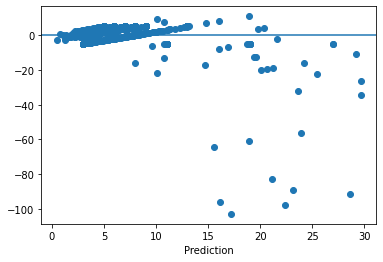

In [68]:
plt.scatter(y_pred_train, residuals_training)
plt.axhline(y=0)
plt.xlabel('Prediction')
plt.show()

The error is greatly reduced compared to the KNN model, though it follows a similar trend. Predicted values of less than 15 have fewer residuals than the KNN model.

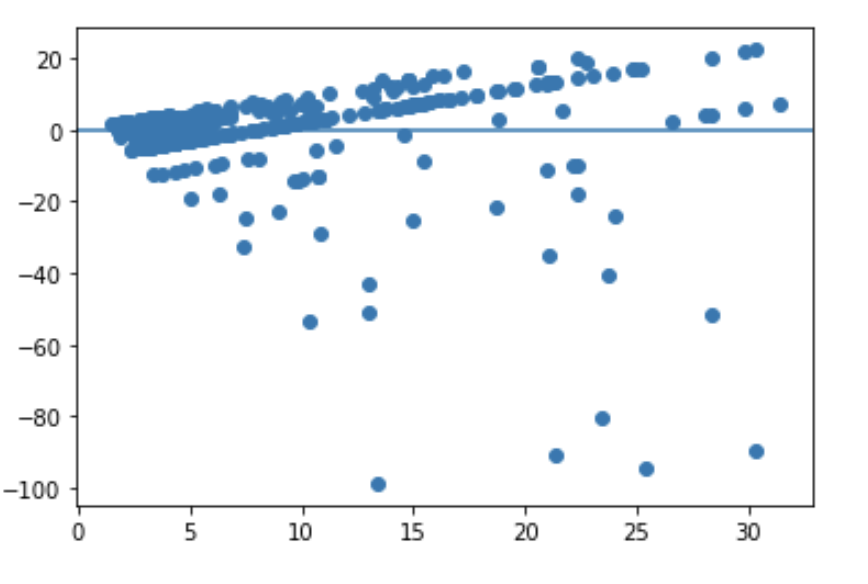